In [32]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import json
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from my_utilities import read_data

In [2]:
# read the data
whole_data, tr_data, ts_data = read_data()

Check the p-value of the whole series, training data e test data to check if it's stationary

In [3]:
pvalue = adfuller(whole_data)[1]
print('p-value of the whole series: %f' % pvalue)
pvalue = adfuller(tr_data)[1]
print('p-value of the training data: %f' % pvalue)
pvalue = adfuller(ts_data)[1]
print('p-value of the test data: %f' % pvalue)

p-value of the whole series: 0.000000
p-value of the training data: 0.000000
p-value of the test data: 0.000000


They are all stationary

To find the **AR order**, plot the **partial autocorrelation**

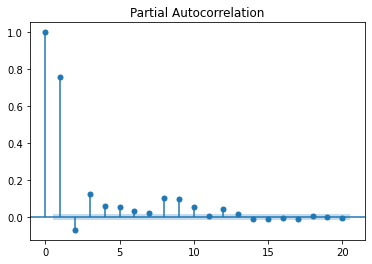

In [4]:
plot_pacf(tr_data, lags=20)
plt.show()

Set the AR order

In [5]:
ar_order = 5

To find the **MA order**, plot the **autocorrelation**

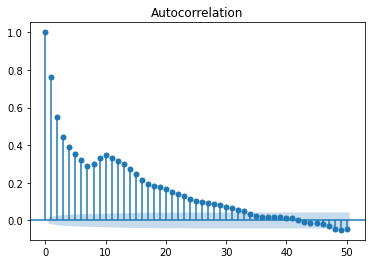

In [6]:
plot_acf(tr_data, lags=50)
plt.show()

Set the MA order

In [7]:
ma_order = 3

Create and fit an AR model, a MA one and an ARMA one

In [9]:
ar = ARIMA(endog=tr_data, order=(ar_order, 0, 0))
ma = ARIMA(endog=tr_data, order=(0, 0, ma_order))
arma = ARIMA(endog=tr_data, order=(ar_order, 0, ma_order))
res_ar = ar.fit()
res_ma = ma.fit()
res_arma = arma.fit()

Check the models' coefficients to see if there are irrelevant ones

In [10]:
print(f"AR model's coefficients: {res_ar.arparams}")
print(f"MA model's coefficients: {res_ma.maparams}")
print(f"ARMA model's AR coefficients: {res_arma.arparams}")
print(f"ARMA model's MA coefficients: {res_arma.maparams}")

AR model's coefficients: [ 0.81202175 -0.16319037  0.07975819  0.01541432  0.05563371]
MA model's coefficients: [0.83532467 0.48908294 0.21892564]
ARMA model's AR coefficients: [ 0.2622909   0.90451224 -0.08570204 -0.19385362  0.0527056 ]
ARMA model's MA coefficients: [ 0.53637449 -0.64691054 -0.45032385]


We can see that some coefficients are near zero.
Let's try to change them a bit:

In [11]:
ar_order = 3
ma_order = 4
arma_ar_order = 3
arma_ma_order = 1
ar = ARIMA(endog=tr_data, order=(ar_order, 0, 0))
ma = ARIMA(endog=tr_data, order=(0, 0, ma_order))
arma = ARIMA(endog=tr_data, order=(arma_ar_order, 0, arma_ma_order))
res_ar = ar.fit()
res_ma = ma.fit()
res_arma = arma.fit()
print(f"AR model's coefficients: {res_ar.arparams}")
print(f"MA model's coefficients: {res_ma.maparams}")
print(f"ARMA model's AR coefficients: {res_arma.arparams}")
print(f"ARMA model's MA coefficients: {res_arma.maparams}")

AR model's coefficients: [ 0.82274631 -0.16953783  0.12089911]
MA model's coefficients: [0.84547571 0.51511217 0.30238695 0.13767543]
ARMA model's AR coefficients: [ 1.62896096 -0.81327326  0.16156719]
ARMA model's MA coefficients: [-0.83525517]


These coefficients look pretty good, no one is too near to zero.

Make **predictions** with retraining for one day.<br>
**AR model**:

  0%|          | 0/144 [00:00<?, ?it/s]

MAE:  34.492067449048534


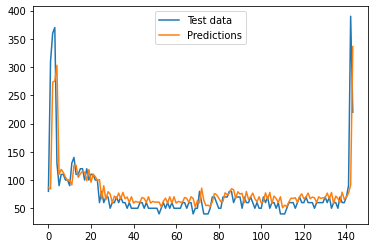

In [12]:
n_pred = 24 * 6
predictions = []
for i in tqdm(range(n_pred)):
    predictions.append(res_ar.forecast(steps=1))
    tr_data = np.concatenate((tr_data, [ts_data[i]]))
    ar = ARIMA(endog=tr_data, order=(ar_order, 0, 0))
    res_ar = ar.fit()

mae = np.mean(np.abs(np.subtract(predictions, ts_data[:n_pred])))
print("MAE: ", mae)
plt.plot(ts_data[:n_pred], label="Test data")
plt.plot(predictions, label="Predictions")
plt.legend()
plt.show()

Test the models on the whole test set with different retraining policies

In [45]:
from serial_training import train

# the order of this list is important: first all the entries of one model, the all the ones of another model etc
# don't "mix" the models
combos = [
    {"order_ar": 3, "order_ma": 0, "err_thresh": 10},
    {"order_ar": 3, "order_ma": 0, "err_thresh": 50},
    {"order_ar": 3, "order_ma": 0, "err_thresh": 100},
    {"order_ar": 3, "order_ma": 1, "err_thresh": 10},
    {"order_ar": 3, "order_ma": 1, "err_thresh": 50},
    {"order_ar": 3, "order_ma": 1, "err_thresh": 100},
    {"order_ar": 2, "order_ma": 0, "err_thresh": 0}
]

for combo in combos:
    # this functions saves the results on some files
    train(**combo, tr_data=copy.deepcopy(tr_data), ts_data=ts_data, retrain=True)

Check the results

In [66]:
def autolabel(ax, rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# function to make the bar-plots of the results
def bar_plots(series, ar_order, arma_ar_order, arma_ma_order):
    labels = [f"AR({ar_order})", f"ARMA({arma_ar_order}, {arma_ma_order})"]
    series_list = list(series.values())
    series0, series1, series2 = series_list[0], series_list[1], series_list[2]
    x = np.arange(len(labels))
    bars_width = 0.2
    fig, ax = plt.subplots(figsize=(10, 7))
    r1 = ax.bar(x - bars_width, series0, bars_width, label="Error threshold: " + str(list(series.keys())[0]))
    r2 = ax.bar(x, series1, bars_width, label="Error threshold: " + str(list(series.keys())[1]))
    r3 = ax.bar(x + bars_width, series2, bars_width, label="Error threshold: " + str(list(series.keys())[2]))
    ax.set_ylabel("MAE")
    ax.set_title("Mean Absolute Error")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    autolabel(ax, r1)
    autolabel(ax, r2)
    autolabel(ax, r3)
    # fig.tight_layout()
    plt.show()

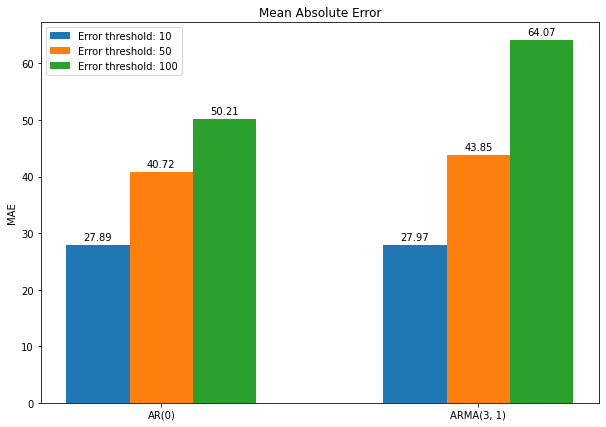

In [67]:
# read the data from files
filenames = [str(c["order_ar"]) + "_" + str(c["order_ma"]) + "_" + str(c["err_thresh"]) + "_retrain.json" for c in combos]
try:
    filenames.remove("2_0_0_retrain.json")
except ValueError:
    pass
series = {10: [], 50: [], 100: []}
for i, fn in enumerate(filenames):
    with open(fn, 'r') as f:
        mae = json.load(f)
        mae = round(mae["mae"], 2)
    series[combos[i]["err_thresh"]].append(mae)
    if i < 3:
        ar_order = combos[i]["order_ma"]
    else:
        arma_ar_order = combos[i]["order_ar"]
        arma_ma_order = combos[i]["order_ma"]

# call the function to generate the bar-plots
bar_plots(series, ar_order, arma_ar_order, arma_ma_order)


**MA model**:

In [14]:
# _, tr_data, ts_data = read_data()
# err = 0
# predictions = []
# for i in tqdm(range(24*6)):
#     predictions.append(res_ma.forecast(steps=1))
#     tr_data = np.concatenate((tr_data, [ts_data[i]]))
#     ma = ARIMA(endog=tr_data, order=(0, 0, ma_order))
#     res_ma = ma.fit()
#
# mae = np.mean(np.abs(np.subtract(predictions, ts_data[:24*6])))
# print("MAE: ", mae)
# plt.plot(ts_data[:24*6], label="Test data")
# plt.plot(predictions, label="Predictions")
# plt.legend()
# plt.show()

  0%|          | 0/144 [00:00<?, ?it/s]

KeyboardInterrupt: 

**ARMA model**:

In [14]:
# _, tr_data, ts_data = read_data()
# predictions = []
# for i in tqdm(range(n_pred)):
#     predictions.append(res_arma.forecast(steps=1))
#     tr_data = np.concatenate((tr_data, [ts_data[i]]))
#     arma = ARIMA(endog=tr_data, order=(arma_ar_order, 0, arma_ma_order))
#     res_arma = arma.fit()
#
# mae = np.mean(np.abs(np.subtract(predictions, ts_data[:24*6])))
# print("MAE: ", mae)
# plt.plot(ts_data[:n_pred], label="Test data")
# plt.plot(predictions, label="Predictions")
# plt.legend()
# plt.show()


  0%|          | 0/144 [00:00<?, ?it/s]

d:\projects\ispr-midterms\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\projects\ispr-midterms\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


KeyboardInterrupt: 